In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# general imports
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

In [3]:
## put your path to your vape repo here 
path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# Bit hacky but oh well
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))
sys.path.append(popoff_path)

In [136]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)



In [71]:
import utils.utils_funcs as uf
from subsets_analysis import Subsets
import pickle
import popoff

from Session import Session, SessionLite, build_flu_array_single

In [5]:
mouse = 'RL117'
run_number = 30

pkl_path = '/home/clean_python/code/Vape/run_pkls/'

In [6]:
def load_pupil(mouse, run_number):
    
    qnap_path = '/home/jrowland/mnt/qnap/Data'
    
    if run_number == 29:
        proc_file = '2021-03-09/2021-03-09_RL117_pupil/2021-03-09_RL117_pupil_proc.npy'
    if run_number == 30:
        proc_file = '2021-03-10/2021-03-10_RL117_pupil/2021-03-10_RL117_pupil_proc.npy'
        
    file_path = os.path.join(qnap_path, proc_file)
    proc = np.load(file_path, allow_pickle=True).item()
    
    
    pupil = proc['pupil'][0]['area_smooth']
    
    return pupil

def mad_point_remover(y, remove_threshold, plot=False):
    # For cutting off the mad points
    to_remove = np.where(y>remove_threshold)[0]
    Min = np.where(y>remove_threshold)[0][0]
    Max = np.where(y>remove_threshold)[0][-1]
    y[y > remove_threshold] = np.mean((y[Min-20:Min] + y[Max+1:Max+21])/2)
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(y, '.')
        plt.axhline(remove_threshold)
    
    return y


def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

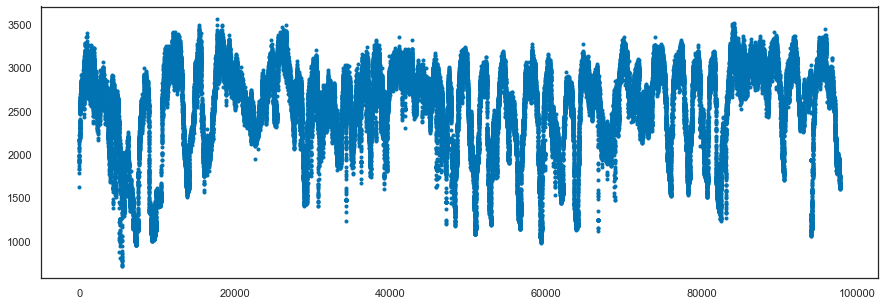

In [81]:

pupil = load_pupil(mouse, run_number)
run = load_run(mouse, run_number, pkl_path)

# Find out which recorded triggers were matched to the
# imaging frames. Assumes that imaging and pupil frames
# occur at roughly the same time
idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
assert sum(idx_imaged) == run.flu.shape[1]
pupil = pupil[idx_imaged]

# Make this work with lots of mice
if run_number == 30:
    remove_threshold = 3700

pupil = mad_point_remover(pupil, remove_threshold, plot=True)
# Add an extra dimension so an array can be built in the same 
# was as flu
run.pupil = np.expand_dims(pupil, 0)

In [64]:
session = SessionLite(mouse, run_number, pkl_path, 'flu', pre_gap_seconds=0, post_gap_seconds=0)

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py
Now loading mouse RL117, run 30
/home/clean_python/code/Vape/run_pkls/RL117/run30.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 69, 1: 73, 2: 78}
Occurence table:
[[64.  5.]
 [58. 15.]
 [51. 27.]]
204 / 733 cells filtered
198 / 198 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]


In [115]:
pupil_arr = build_flu_array_single(run, use_pupil=True, pre_frames=session.pre_frames,
                                   post_frames=session.post_frames)
pupil_arr = pupil_arr[:, session.nonnan_trials, :].squeeze()
pupil_arr.shape

# Baseline the pupil
baseline = np.mean(pupil_arr[:, :session.pre_frames], 1)
pupil_arr = np.subtract(pupil_arr.T, baseline).T

In [93]:
session.pre_frames

120

Text(0.5, 0, 'Time')

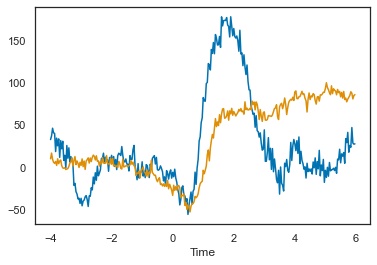

In [117]:
x_axis = (np.arange(pupil_arr.shape[1]) - session.pre_frames) / 30
plt.plot(x_axis, np.mean(pupil_arr[session.outcome=='hit'], 0))
plt.plot(x_axis, np.mean(pupil_arr[session.outcome=='miss'], 0))

plt.xlabel('Time')


In [142]:
def lineplot_matrix(data, x_axis, color, label):

    df = pd.DataFrame(data).melt()
    df['time (seconds)'] = np.repeat(x_axis, data.shape[0])

    sns.lineplot(x='time (seconds)', y='value', data=df, color=color,
                label=label)
    

In [ ]:
lineplot_matrix(data=pupil_arr[session.outcome=='hit'], x_axis=x_axis, color=COLORS[0], label='hit')
lineplot_matrix(data=pupil_arr[session.outcome=='miss'], x_axis=x_axis, color=COLORS[1], label='miss')
# lineplot_matrix(data=pupil_arr[session.outcome=='fp'], x_axis=x_axis, color='orange', label='fp')
# lineplot_matrix(data=pupil_arr[session.outcome=='cr'], x_axis=x_axis, color='pink', label='cr')
plt.ylabel('Pupil Area (AU)')

